* Reference: 
__Pairs Trading: Performance of a Relative Value Arbitrage Rule__ _by_ Gatev et al.<br>
$\;\;\;\;\;\;\;\;\;\;\;\;\;$ __Are Pairs Trading Profits Robust to Trading Costs?__ _by_ Do et al.<br>
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$__Does Simple Pairs Trading Still Work?__ _by_ Do et al.

# Basic Distance Approach Comparison

This notebook aims to give a comprehensive comparison of different pairs selection methods described in our previous notebook for the basic distance approach. As in the work by Do and Faff (2010), we’ll make a portfolio for the top 20 pairs of each selection method. All selection methods are as below:

1. **Basic Strategy**: By calculating the Euclidean square distance for each of the pairs, the $n$ closest pairs are selected.


2. **Industry Strategy**: By calculating the Euclidean square distance for each of the pairs within the same industry group, the $n$ closest pairs are selected.


3. **Zero-crossings Strategy**: After pairs were matched within the same industry group, the top $n$ pairs that had the highest number of zero crossings during the 12-month formation period are selected.


4. **Variance Strategy**: By sorting the pairs based on their historical standard deviation in the formation period, the top $n$ pairs with higher standard deviation are selected


5. **Cointegration Strategy**: After select 50 pairs based on Industry Strategy, by conducting a cointegration test, the top $n$ pairs with smaller p-values are selected.

# Introduction

We’ll use Arbitrage Lab’s Basic Distance Approach module to show comparisons in this notebook. Therefore, we highly recommend seeing [here](https://hudson-and-thames-arbitragelab.readthedocs-hosted.com/en/latest/distance_approach/distance_approach.html) for more details of the module.

This notebook goes as follow:
- First, we load data and modules we need for comparisons. One may use different sources of data if the data structure is the same as the given example.
- Second, by using the 5 different pairs selection method, we’ll create 5 different strategies.
- After pairs are selected, the empirical test is conducted using test data and see which strategy performs better for the given period. 

# Implementation

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import itertools
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 

## Loading Data

As we did in the research notebook(basic_distance_approach) for Basic Disatance Approach module, we'll download price time series for 272 stocks over a period from 01.2018 to 07.2019. First 12 months of data will be used for training and the following 6 months for trading signal generation and analysis of results. 

Also, for industry-group based selection, we’ll use 4 major industries in S&P 500 stocks: Information Technology, Industrials, Financials and Healthcare. We’ll download this data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) but any source of data is welcome to use if you follow the dictionary as below.

In [3]:
# Get industry data from Wikipedia 
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stock_table = table[0]

# Indutry groups to use are below
industry_group = ['Information Technology','Industrials','Financials',
                  'Health Care']

# Get tickers from S&P 500 which are in those industry groups
ticker_industry = stock_table[stock_table['GICS Sector']
                              .isin(industry_group)].reset_index(drop=True)

# Get a dataframe of ticker and industry group
ticker_industry = ticker_industry[['Symbol','GICS Sector']]

# Get tickers to use as a list
tickers = ticker_industry['Symbol'].to_list()
remove_tickers = ['CARR','ABC','BRK.B','VNT','OTIS'] # Removed tickers
tickers = [ticker for ticker in tickers if ticker not in remove_tickers]

# Get a dictionary of industry group
industry_dict = pd.Series(ticker_industry['GICS Sector'].values,
                        index=ticker_industry['Symbol']).to_dict()

# Loading data
train_data =  yf.download(tickers, start="2018-01-03", end="2019-01-01")
test_data =  yf.download(tickers, start="2019-01-02", end="2019-07-01")

# Taking close prices for chosen instruments
train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

# Looking at the downloaded data
train_data.head()

[*********************100%***********************]  272 of 272 completed
[*********************100%***********************]  272 of 272 completed


,A,AAL,AAPL,ABBV,ABMD,ABT,ACN,ADBE,ADI,ADP,...,WRB,WST,WU,XLNX,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.877853,51.647556,41.380238,83.965569,192.490005,55.684303,146.372726,177.699997,84.586998,108.099258,...,43.993813,98.066849,16.841452,64.657593,65.490776,65.376862,121.132782,103.709999,46.290783,70.380058
2018-01-03,67.554039,51.014027,41.373032,85.279503,195.820007,55.807426,147.048264,181.039993,85.636383,109.273544,...,43.629505,98.185112,16.832628,65.953041,65.266426,66.174019,121.972481,105.769997,46.236004,70.703651
2018-01-04,67.047279,51.335667,41.565216,84.793175,199.250000,55.712711,148.789413,183.220001,85.542686,110.317375,...,43.805378,98.155556,17.168045,67.143723,65.256653,66.615829,121.796738,107.860001,46.427734,71.125328
2018-01-05,68.119247,51.316177,42.038452,86.269249,202.320007,55.873722,150.016815,185.339996,85.889336,110.252121,...,43.623226,99.387543,18.183119,70.629974,66.173569,66.490967,123.007484,109.540001,46.445999,71.939262
2018-01-08,68.265442,50.809345,41.882305,84.887016,207.800003,55.712711,151.215637,185.039993,86.039261,109.916618,...,43.403381,99.949333,18.968700,71.096703,66.622284,66.731087,123.241814,110.629997,46.217739,72.802223


## Pair Selection Methods

To learn the details of each of the pairs selection methods, please refer to our [documentation](https://hudson-and-thames-arbitragelab.readthedocs-hosted.com/en/latest/distance_approach/distance_approach.html). 

As mentioned above, we’ll select the top 15 pairs for each strategy. However, for the cointegration strategy, we’ll select the top 50 pairs first and test the cointegrating relationship between pairs so that we can select the top 15 pairs that are most cointegrated. 

In [4]:
# Defining three different pair selection criteria 
strategy_basic = al.distance_approach.DistanceStrategy()
strategy_industry = al.distance_approach.DistanceStrategy()
strategy_zero_crossing = al.distance_approach.DistanceStrategy()
strategy_variance = al.distance_approach.DistanceStrategy()
strategy_coint = al.distance_approach.DistanceStrategy()

# Performing the pairs formation step and picking top 15 pairs
strategy_basic.form_pairs(train_data, num_top=15)
strategy_industry.form_pairs(train_data, industry_dict=industry_dict, 
                             num_top=15)
strategy_zero_crossing.form_pairs(train_data, method='zero_crossing', 
                             industry_dict=industry_dict, num_top=15)
strategy_variance.form_pairs(train_data, method='variance',
                             industry_dict=industry_dict, num_top=15)
strategy_coint.form_pairs(train_data, industry_dict=industry_dict, 
                          num_top=50)

Here, by using a module from [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html), the Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the p-value is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

Below is a simple function returning a list containing tuples of two strings that are cointegrated. One may use the function to test the cointegration of the pairs. There is also a cointegration module in our Arbitrage Lab so we highly recommend reading [here](https://hudson-and-thames-arbitragelab.readthedocs-hosted.com/en/latest/cointegration_approach/cointegration_tests.html) and utilize it as well.

In [5]:
def get_coint_pairs(pairs, train_data, critical_val=0.05):
    """
    Selects pairs which are cointegrated at the given critical values only.

    For cointegration test, Engle-Granger two-step cointegration test is used.

    :param pairs: (list) List containing tuples of two strings, for names of elements in a pair.
    :param train_data: (pd.DataFrame) Dataframe with training data used to create asset pairs.
    :param critical_val: (float) Critical value to reject the null hypothesis. By default, it's 0.05.
    :return pairs_coint: (list) List containing tuples of two strings that are cointegrated.
    """

    # Make an empty dictionary for cointegrated pairs
    pairs_coint = {}

    # Perform hypothesis test for every pair in the pairs list
    for pair in pairs:

        # Select each stock in the pair
        first_ticker = pair[0]
        second_ticker = pair[1]

        # Get data for each of the stock with scaling parameter
        first_stock = train_data[first_ticker].fillna(method='ffill')

        second_stock = train_data[second_ticker].fillna(method='ffill')

        # Conduct a cointegration test and get p-value
        p_value = ts.coint(first_stock.values, second_stock.values)[1]

        # Check whether the p-value is below the critical value and add to a list if it is.
        if p_value < critical_val:
            pairs_coint[pair] = p_value

    return pairs_coint

In [6]:
# Get pairs and scaling parameter for cointegration strategy
pairs_coint = strategy_coint.get_pairs()
scaling_coint = strategy_coint.get_scaling_parameters()

# Get a dictionary of pairs and p-value after the cointegration test
pairs_coint = get_coint_pairs(pairs_coint, train_data)

# Sort a dictionary by its item values
pairs_coint = dict(sorted(pairs_coint.items(), key=lambda item: item[1]))

# Get only top 15 pairs from the dictionary
num_top = 15
pairs_coint = list(dict(itertools.islice(pairs_coint.items(), num_top)).keys())

# Assign the selected pairs as the strategy's pairs
strategy_coint.pairs = pairs_coint

We’ll just use the `get_pairs()` method for other strategies to get the top 20 pairs.

In [7]:
# Getting a list of created pairs for each of the strategy
pairs_basic = strategy_basic.get_pairs()
pairs_industry = strategy_industry.get_pairs()
pairs_zero_crossing = strategy_zero_crossing.get_pairs()
pairs_variance = strategy_variance.get_pairs()

Let’s see all the pairs selected by each method. We’ll see the profitability of each pair in the table below after testing all the strategies.

In [8]:
# Showing pairs selected by each method
pair_dataframe = pd.DataFrame([pd.Series(pairs_basic), pd.Series(pairs_industry),pd.Series(pairs_zero_crossing), 
                               pd.Series(pairs_variance),pd.Series(pairs_coint)],
                              index =['Basic','Industry','Zero-Crossing','Variance','Cointegration']).T
display(pair_dataframe)

,Basic,Industry,Zero-Crossing,Variance,Cointegration
0,"(ISRG, V)","(HBAN, KEY)","(CFG, GS)","(ADP, MSFT)","(FITB, MS)"
1,"(HBAN, KEY)","(MTB, PNC)","(AAL, ITW)","(MSFT, VRSN)","(COF, KEY)"
2,"(MTB, PNC)","(LNC, PRU)","(BLK, STT)","(BAC, COF)","(AAL, ITW)"
3,"(LNC, PRU)","(CMA, RF)","(ADBE, MA)","(MRK, PFE)","(BLK, STT)"
4,"(CMA, RF)","(PFG, PRU)","(FITB, MTB)","(CRM, V)","(AMAT, WDC)"
5,"(PFG, PRU)","(BLK, STT)","(ADP, MSFT)","(AMAT, WDC)","(ADBE, NOW)"
6,"(BLK, STT)","(FBHS, MAS)","(PFG, PRU)","(CFG, FITB)","(ADP, V)"
7,"(FBHS, MAS)","(MSFT, V)","(MSFT, V)","(GD, NOC)","(LLY, MRK)"
8,"(MSFT, V)","(LLY, PFE)","(MS, PNC)","(CMA, NTRS)","(FBHS, MAS)"
9,"(LLY, PFE)","(AIG, HIG)","(ILMN, ISRG)","(MCO, SPGI)","(CFG, GS)"


## Testing strategies

Now we’ll test each of the strategies by forming an equally weighted portfolio with the selected pairs. 

Here, we follow the trading rule by Do and Faff (2010). If the portfolio value exceeds two historical deviations, a sell signal is generated - we expect the price of the first element to decrease and the price of the second element to increase. And if the value of the portfolio is below minus two historical deviations, a buy signal is generated.

An open position is closed when the portfolio value crosses the zero mark - or when the prices of elements in a pair cross. So at any given time, we have one (buy or sell) or none active positions opened. This makes cost allocation for the strategy easier. The resulting trading signals are target quantities of portfolios to hold for each pair (with values -1, 0, or +1).

In the get_portfoio_return function below, we generate these signals and trade based on these for every portfolio. Then we average the returns of the portfolios by equal weight for simple comparison. 

In [9]:
def get_portfolio_return(strategy, test_data):
    """
    Ouputs a series of portfolio returns for a given strategy.

    :params strategy: (Class) DistanceStratgey Class with pairs formed with form_pair()
    :params test_data: (pd.DataFrame) Dataframe with testing data used to create trading signals.
    :params pairs: (list) List containing tuples of two strings, for names of elements in a pair.
    :return: (pd.Series) Series of portfolio returns in the test period
    """

    # Getting a list of created pairs for each chosen pair portfolio
    pairs = strategy.get_pairs()

    # Performing the signal generation stage using (2 * st. variation) as a threshold
    strategy.trade_pairs(test_data, divergence=2)

    # Getting series of portfolio values, trading signals, and normalized price series of elements for each chosen pair
    index_columns = [str(pair) for pair in pairs]
    portfolio_series = strategy.get_portfolios()
    portfolio_series = portfolio_series.loc[:,portfolio_series.columns.isin(index_columns)]
    trading_signals = strategy.get_signals()
    trading_signals = trading_signals.loc[:,trading_signals.columns.isin(index_columns)]

    # Returns of elemrnts in a test dataset
    test_data_returns = (test_data / test_data.shift(1) - 1)[1:]

    # Making empty dataframe and list for storing returns of the pairs
    total_return = pd.Series([], dtype='float64')
    pair_return = []
    
    for pair in pairs:
        first_stock, second_stock = pair
        portfolio_returns_scaled = test_data_returns[first_stock] * 0.5 - test_data_returns[second_stock] * 0.5
        portfolio_returns_scaled = portfolio_returns_scaled * (trading_signals[str(pair)].shift(1))
        portfolio_price_scaled = (portfolio_returns_scaled + 1).cumprod()

        # Equity curve of our scaled portfolio price
        equity_curve_scaled = portfolio_price_scaled - 1
        
        # Appends the return of the pair into the list and total return into the dataframe
        pair_return.append(equity_curve_scaled[-1])
        total_return = total_return.add(equity_curve_scaled, fill_value=0)
    
    # Reformatting the returns of the pairs for better visualization later
    pair_return = [ '%.4f' % value for value in pair_return ]
    
    # Calculates the average return of the portfolio
    total_return = total_return/len(pairs)
    
    return pair_return, total_return

Below are the results of the test for every portfolio. 

Investment portfolio value rose to  0.010281514960102952


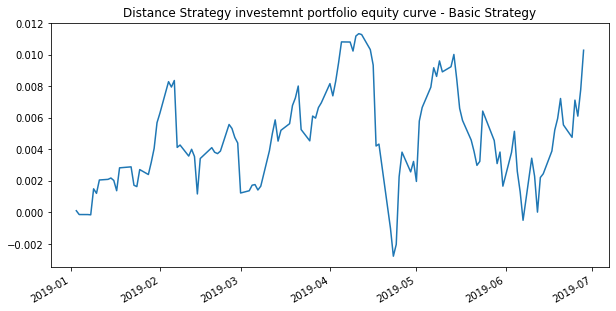

In [10]:
# Get portfolio return for basic strategy
pair_return_basic, portfolio_basic = get_portfolio_return(strategy_basic, test_data)

# Plot the equity curve and print the excess return of the portfolio
portfolio_basic.plot(title='Distance Strategy investemnt portfolio equity curve - Basic Strategy', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_basic[-1])

Investment portfolio value rose to  0.017952189546626383


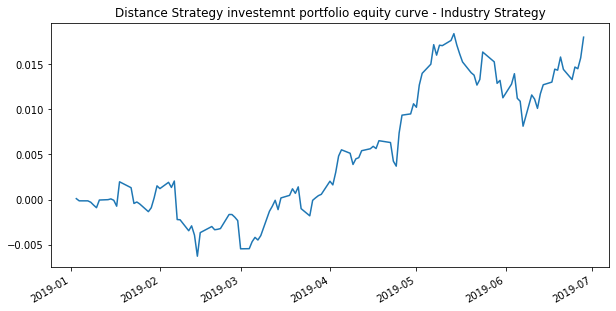

In [11]:
# Get portfolio return for industry strategy
pair_return_industry, portfolio_industry = get_portfolio_return(strategy_industry, test_data)

# Plot the equity curve and print the excess return of the portfolio
portfolio_industry.plot(title='Distance Strategy investemnt portfolio equity curve - Industry Strategy', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_industry[-1])

Investment portfolio value rose to  0.00914379772409814


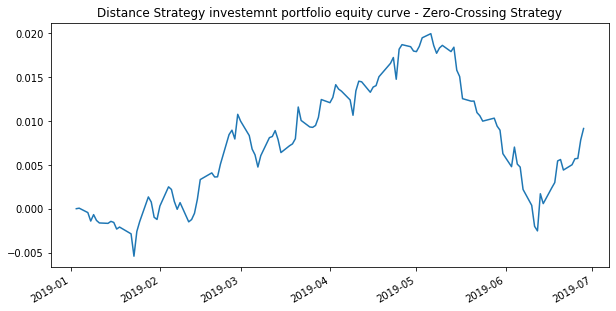

In [12]:
# Get portfolio return for variance strategy
pair_return_zero_crossing, portfolio_zero_crossing = get_portfolio_return(strategy_zero_crossing, test_data)

# Plot the equity curve and print the excess return of the portfolio
portfolio_zero_crossing.plot(title='Distance Strategy investemnt portfolio equity curve - Zero-Crossing Strategy', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_zero_crossing[-1])

Investment portfolio value rose to  0.02158264119280564


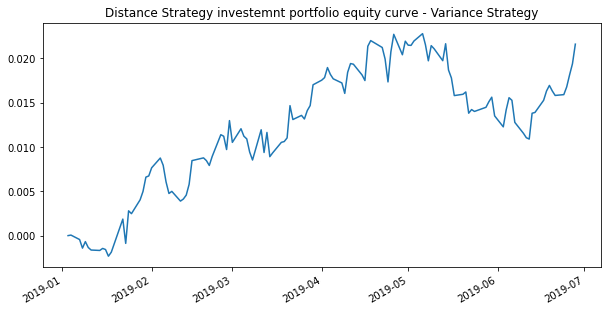

In [13]:
# Get portfolio return for variance strategy
pair_return_variance, portfolio_variance = get_portfolio_return(strategy_variance, test_data)

# Plot the equity curve and print the excess return of the portfolio
portfolio_variance.plot(title='Distance Strategy investemnt portfolio equity curve - Variance Strategy', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_variance[-1])

Investment portfolio value rose to  0.008734493462658689


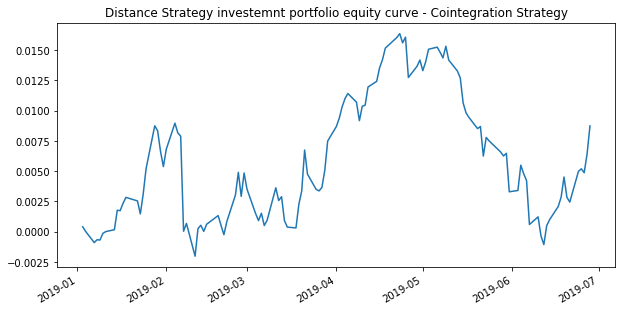

In [14]:
# Get portfolio return for cointegration strategy
pair_return_coint, portfolio_coint = get_portfolio_return(strategy_coint, test_data)

# Plot the equity curve and print the excess return of the portfolio
portfolio_coint.plot(title='Distance Strategy investemnt portfolio equity curve - Cointegration Strategy', figsize=(10,5));
print('Investment portfolio value rose to ', portfolio_coint[-1])

Before we wrap up, one may look into the details of portfolio returns for each pair as below. One thing to note is that although the variance method has the highest portfolio return among the five methods, it has two pairs with zero returns implying that these pairs are not traded at all during the test period. As it might not be the most desirable result we want from pairs trading, some other combinations of methods could be tried using the module. 

In [15]:
# Showing pairs selected by each method and its returns
pair_returns = pd.DataFrame([pairs_basic, pair_return_basic,pairs_industry, pair_return_industry,
                pairs_zero_crossing, pair_return_zero_crossing,pairs_variance,pair_return_variance,
                pairs_coint, pair_return_coint]).T
columns = ['Basic','Return' ,'Industry','Returns','Zero-Crossing','Returns','Variance','Returns','Cointegration','Returns']
pair_returns.columns = columns
display(pair_returns)

,Basic,Return,Industry,Returns,Zero-Crossing,Returns,Variance,Returns,Cointegration,Returns
0,"(ISRG, V)",-0.0035,"(HBAN, KEY)",0.0221,"(CFG, GS)",0.0457,"(ADP, MSFT)",0.0139,"(FITB, MS)",0.0394
1,"(HBAN, KEY)",0.0221,"(MTB, PNC)",0.0361,"(AAL, ITW)",-0.0027,"(MSFT, VRSN)",0.0194,"(COF, KEY)",0.0707
2,"(MTB, PNC)",0.0361,"(LNC, PRU)",-0.0046,"(BLK, STT)",-0.1420,"(BAC, COF)",0.0425,"(AAL, ITW)",-0.0027
3,"(LNC, PRU)",-0.0046,"(CMA, RF)",0.0352,"(ADBE, MA)",-0.0184,"(MRK, PFE)",-0.0361,"(BLK, STT)",-0.1420
4,"(CMA, RF)",0.0352,"(PFG, PRU)",0.0499,"(FITB, MTB)",0.0386,"(CRM, V)",-0.0450,"(AMAT, WDC)",0.0142
5,"(PFG, PRU)",0.0499,"(BLK, STT)",-0.1420,"(ADP, MSFT)",0.0139,"(AMAT, WDC)",0.0142,"(ADBE, NOW)",-0.0897
6,"(BLK, STT)",-0.1420,"(FBHS, MAS)",0.0594,"(PFG, PRU)",0.0499,"(CFG, FITB)",0.0000,"(ADP, V)",0.0120
7,"(FBHS, MAS)",0.0594,"(MSFT, V)",0.0383,"(MSFT, V)",0.0383,"(GD, NOC)",0.0131,"(LLY, MRK)",-0.0218
8,"(MSFT, V)",0.0383,"(LLY, PFE)",0.0192,"(MS, PNC)",0.0216,"(CMA, NTRS)",0.0324,"(FBHS, MAS)",0.0594
9,"(LLY, PFE)",0.0192,"(AIG, HIG)",0.0324,"(ILMN, ISRG)",0.0261,"(MCO, SPGI)",0.0000,"(CFG, GS)",0.0457


# Conclusion

Among the 5 different strategies, the variance method performs better than the others in the test period. Seeing the plot, the portfolio seems to perform steadily well during the period but still has some critical drawdowns in June 2019. 

As this notebook conducted testing with one period of time for the strategies, this might not be always the case that the variance strategy performs the best. One may perform these in different time periods and data. 

Key takeaways from the notebook:
- As in the work by Do and Faff (2010), the basic method performs worst among 5 different strategies, which means additional pairs selection method might be needed other than the basic distance approach.
- The variance method performs well as theoretically, the pairs with higher standard deviation in the formation period assure more volatile spreads, resulting in higher profit opportunities in the testing period.
- Conducting a cointegration test after pair selection to select pairs that have a high cointegrating relationship works as the cointegration strategy performs better than the basic and industry strategy.